In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import PIL
import librosa
import librosa.display

import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

import numpy as np

from skimage.io import imread
from collections import namedtuple
import matplotlib.pyplot as plt
from IPython.display import display as dis, Audio

from cs7643.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
%matplotlib inline

## Audio Utils

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in np.arange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start:stop]

    return out


def stft(
    X, fftsize=128, step=65, mean_normalize=True, real=False, compute_onesided=True
):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X


def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(
        stft(d, fftsize=fft_size, step=step_size, real=False, compute_onesided=True)
    )

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[
            specgram < -thresh
        ] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[
            specgram < thresh
        ] = thresh  # set anything less than the threshold as the threshold

    return specgram


# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(
    X_s, log=True, fft_size=512, step_size=512 / 4, n_iter=10
):

    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t


def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1e8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=True
            )
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=False
            )
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[: len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True, set_zero_phase=False)
    return np.real(X_t)


def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype("float64")
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print(
                    "WARNING: Large step size >50\% detected! "
                    "This code works best with high overlap - try "
                    "with 75% or greater"
                )
                offset_size = step
            offset = xcorr_offset(
                wave[wave_start : wave_start + offset_size],
                wave_est[est_start : est_start + offset_size],
            )
        else:
            offset = 0
        wave[wave_start:wave_end] += (
            win * wave_est[est_start - offset : est_end - offset]
        )
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1e-6)
    return wave


def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype("float32"), x2[::-1].astype("float32"))
    corrs[:half] = -1e30
    corrs[-half:] = -1e30
    offset = corrs.argmax() - len(x1)
    return offset


def make_mel(spectrogram, mel_filter, shorten_factor=1):
    mel_spec = np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(
        mel_spec.astype("float32"), [1, 1.0 / shorten_factor]
    ).astype("float16")
    mel_spec = mel_spec[:, 1:-1]  # a little hacky but seemingly needed for clipping
    return mel_spec


def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = mel_spec + spec_thresh
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(
        uncompressed_spec.astype("float32"), [1, shorten_factor]
    ).astype("float16")
    uncompressed_spec = uncompressed_spec - 4
    return uncompressed_spec


# From https://github.com/jameslyons/python_speech_features


def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1 + hz / 700.0)


def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700 * (10 ** (mel / 2595.0) - 1)


def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft + 1) * mel2hz(melpoints) / samplerate)

    fbank = np.zeros([nfilt, nfft // 2])
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    return fbank


def create_mel_filter(
    fft_size, n_freq_components=64, start_freq=300, end_freq=8000, samplerate=44100
):
    """
    Creates a filter to convolve with the spectrogram to get out mels

    """
    mel_inversion_filter = get_filterbanks(
        nfilt=n_freq_components,
        nfft=fft_size,
        samplerate=samplerate,
        lowfreq=start_freq,
        highfreq=end_freq,
    )
    # Normalize filter
    mel_filter = mel_inversion_filter.T / mel_inversion_filter.sum(axis=1)

    return mel_filter, mel_inversion_filter


In [3]:
### Parameters ###
fft_size = 2048  # window size for the FFT
step_size = fft_size // 16  # distance to slide along the window (in time)
spec_thresh = 4  # threshold for spectrograms (lower filters out more noise)
lowcut = 500  # Hz # Low cut for our butter bandpass filter
highcut = 15000  # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64  # number of mel frequency channels
shorten_factor = 10  # how much should we compress the x-axis (time)
start_freq = 300  # Hz # What frequency to start sampling our melS from
end_freq = 8000  # Hz # What frequency to stop sampling our melS from

## Helper Functions

In [4]:
def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = Variable(img.type(dtype))
    return extract_features(img_var, cnn), img_var

def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Variable of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Variable of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [5]:
class CNNModel(nn.Module):
        def __init__(self):
            super(CNNModel, self).__init__()
            self.cnn1 = nn.Conv1d(in_channels=128, out_channels=4096, kernel_size=3, stride=1, padding=1)

        def forward(self, x):
            out = self.cnn1(x)
            out = out.view(out.size(0),-1)
            return out

## Content Loss

In [6]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    
    ##############################################################################
    # TODO: Implement content loss function                                      #
    # Please pay attention to use torch tensor math function to finish it.       #
    # Otherwise, you may run into the issues later that dynamic graph is broken  #
    # and gradient can not be derived.                                           #
    ##############################################################################
    difference = (content_current - content_original) ** 2
    out = content_weight * torch.sum(difference)
    return out

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

## Style Loss

In [7]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: PyTorch Variable of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: PyTorch Variable of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """    
    ##############################################################################
    # TODO: Implement content loss function                                      #
    # Please pay attention to use torch tensor math function to finish it.       #
    # Otherwise, you may run into the issues later that dynamic graph is broken  #
    # and gradient can not be derived.                                           #
    #                                                                            #
    # HINT: you may find torch.bmm() function is handy when it comes to process  #
    # matrix product in a batch. Please check the document about how to use it.  #
    ##############################################################################
    N, C, H, W = features.shape
    reduced_F = features.view((N, C, H*W))
    
    mult = torch.bmm(reduced_F, reduced_F.permute((0, 2, 1)))
    if normalize:
        mult /= (C * reduced_F.shape[2])
    return mult
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################


In [8]:
# Now put it together in the style_loss function...
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Variable giving the Gram matrix the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A PyTorch Variable holding a scalar giving the style loss.
    """
    
    ##############################################################################
    # TODO: Implement content loss function                                      #
    # Please pay attention to use torch tensor math function to finish it.       #
    # Otherwise, you may run into the issues later that dynamic graph is broken  #
    # and gradient can not be derived.                                           #
    #                                                                            #
    # Hint:                                                                      #
    # you can do this with one for loop over the style layers, and should not be #
    # very much code (~5 lines). Please refer to the 'style_loss_test' for the   #
    # actual data structure.                                                     #
    #                                                                            #
    # You will need to use your gram_matrix function.                            #
    ##############################################################################
    loss = Variable(torch.tensor(0.0))
    for ndx in range(len(style_layers)):
        currGram = gram_matrix(feats[style_layers[ndx]])
        diffGrams = (currGram - style_targets[ndx]) ** 2
        loss = loss + (style_weights[ndx] * torch.sum(diffGrams))
    
    return loss
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

## Total-variation Regularization

In [9]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    
    ##############################################################################
    # TODO: Implement content loss function                                      #
    # Please pay attention to use torch tensor math function to finish it.       #
    # Otherwise, you may run into the issues later that dynamic graph is broken  #
    # and gradient can not be derived.                                           #
    ##############################################################################
    loss = tv_weight * (torch.sum((img[:,:,:-1,:] - img[:,:,1:,:])**2) + torch.sum((img[:,:,:,:-1] - img[:,:,:,1:])**2))
    return Variable(loss)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

## Style Transfer

In [10]:
cnn = torchvision.models.vgg16(pretrained=True).features
cnn.type(torch.FloatTensor)

# Fix the weights of the pretrained network
for param in cnn.parameters():
    param.requires_grad = False

In [15]:
def style_transfer_audio(content_image, style_images, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """

    y_con, sr_con = librosa.load(content_image)#librosa.util.example_audio_file())
    S_content = librosa.stft(y_con, 2048)
    #S_content = librosa.feature.melspectrogram(y=y_con, sr=sr_con, n_mels=128, fmax=8000)
    S_dB_content = librosa.power_to_db(S_content, ref=np.max)
    
    out_img_spec = spec_to_image(S_dB_content)
    im = PIL.Image.fromarray(out_img_spec)
    im = im.convert('RGB')
    content_img = preprocess(im, size=image_size)
    content_img_var = Variable(content_img.type(torch.FloatTensor))
    feats = extract_features(content_img_var, cnn)
    content_target = feats[content_layer].clone()
    
    all_style_targets = []
    all_style_images = []
    style_targets = []
    for style_image in style_images:
        y_style, sr_style = librosa.load(style_image)#librosa.util.example_audio_file())
        S_style = librosa.stft(y_style, 2048)#librosa.feature.melspectrogram(y=y_style, sr=sr_style, n_mels=128, fmax=8000)
        S_dB_style = librosa.power_to_db(S_style, ref=np.max)

        out_img_spec = spec_to_image(S_dB_style)
        im = PIL.Image.fromarray(out_img_spec)
        im = im.convert('RGB')
        style_img = preprocess(im, size=image_size)
        all_style_images.append(style_img)
        style_img_var = Variable(style_img.type(torch.FloatTensor))

        feats = extract_features(style_img_var, cnn)
        for idx in style_layers:
            style_targets.append(gram_matrix(feats[idx].clone()))
    
        
    style_layers = style_layers * len(style_images)
    style_weights = style_weights * len(style_images)
    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1)
    else:
        img = content_img.clone().type(torch.FloatTensor)

    # We do want the gradient computed on our image!
    img_var = Variable(img, requires_grad=True)

    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img_var Torch variable, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img_var], lr=initial_lr)
    
    print('Content Image')
    plt.axis('off')
    plt.imshow(deprocess(content_img.cpu()))
    plt.show()
    for i, style_img in enumerate(all_style_images):
        print('Style Image ' + str(i))
        plt.axis('off')
        plt.imshow(deprocess(style_img.cpu()))
        plt.show()
    for t in range(800):
        if t < 390:
            img.clamp_(-1.5, 1.5)
        feats = extract_features(img_var, cnn)

        ##############################################################################
        # TODO: Implement this update rule with by forwarding it to criterion        #
        # functions and perform the backward update.                                 #
        #                                                                            #
        # HINTS: all the weights, loss functions are defined. You don't need to add  # 
        # any other extra weights for the three loss terms.                          #
        # The optimizer needs to clear its grad before backward in every step.       #
        ##############################################################################
        optimizer.zero_grad()
        if t == decay_lr_at:
            for param_group in optimizer.param_groups:
                param_group['lr'] = decayed_lr
        
        content = content_loss(content_weight, feats[content_layer], content_target)
        style = style_loss(feats, style_layers, style_targets, style_weights)
        tv = tv_loss(img_var, tv_weight)
        
        all_loss = content + style + tv
        
        all_loss.backward()
        optimizer.step()

        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################        
        
        if t % 100 == 0:
            print('Iteration {}'.format(t))
            print("Content Loss " + str(content.item()))
            print("Style Loss " + str(style.item()))
            print("Total Loss " + str(all_loss.item()))
            plt.axis('off')
            plt.imshow(deprocess(img.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    print(all_loss.item())
    plt.axis('off')
    plt.imshow(deprocess(img.cpu()))
    plt.show()
    return img.cpu()

## Running Style Transfer

/Users/jeffreyjacob/opt/anaconda3/envs/cs7643/lib/python3.7/site-packages/librosa/core/spectrum.py:1607: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  warnings.warn('power_to_db was called on complex input so phase '


Content Image


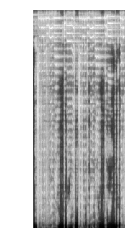

Style Image 0


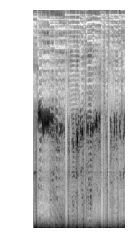

Style Image 1


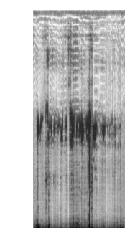

Style Image 2


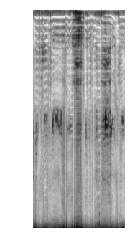

Iteration 0
Content Loss 5259.22802734375
Style Loss 497.1618347167969
Total Loss 6680.29296875


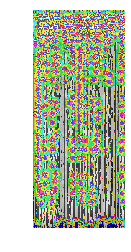

Iteration 100
Content Loss 83654.6640625
Style Loss 2842.255126953125
Total Loss 100149.625


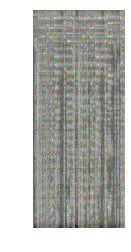

Iteration 200
Content Loss 16954.076171875
Style Loss 1413.1241455078125
Total Loss 32295.48828125


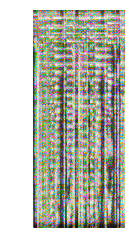

Iteration 300
Content Loss 2795.398193359375
Style Loss 614.1182250976562
Total Loss 12854.4638671875


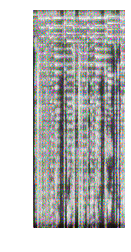

Iteration 400
Content Loss 1605.187744140625
Style Loss 552.9146728515625
Total Loss 9476.251953125


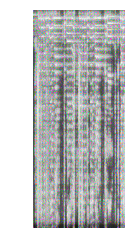

Iteration 500
Content Loss 989.9478759765625
Style Loss 521.5454711914062
Total Loss 7697.4853515625


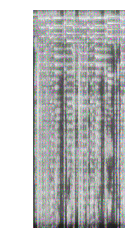

Iteration 600
Content Loss 748.7919311523438
Style Loss 500.91741943359375
Total Loss 6723.7841796875


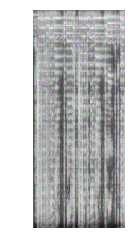

Iteration 700
Content Loss 609.0231323242188
Style Loss 487.3851318359375
Total Loss 6086.18896484375


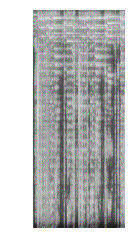

Iteration 799
5641.74853515625


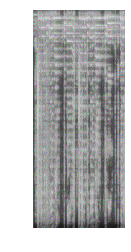

In [16]:
params1 = {
    'content_image': "./weeknd_10sec_sample.wav",
    'style_images': ["./beyonce_10sec_sample.wav", "./beyonce_dang_love_10sec.wav", "./beyonce_resentment_10sec.wav"],
    'image_size' : 128,
    'style_size' : 512,
    'content_layer' : 6,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 3, 6, 9),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

img_out = style_transfer_audio(**params1)

In [17]:
outimg = img_out.squeeze().data.numpy()
deproc = deprocess(img_out)
deproc.save("weekend_bey_mult_vgg.png")
avgout = outimg.mean(axis=0)
y = librosa.feature.inverse.mel_to_audio(avgout, sr=22050)
librosa.output.write_wav('week_beyonce_mult_style_vgg.wav', y, 22050)
dis(Audio(y, rate=22050))

## Noise Reduction

In [14]:
import noisereduce as nr
from scipy.io import wavfile

rate, data = wavfile.read("week_beyonce_mult_style_vgg.wav")
noisy_part = data[:]
reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, verbose=True)
dis(Audio(reduced_noise, rate=22050))

ModuleNotFoundError: No module named 'noisereduce'

In [ ]:
from scipy import ndimage

val = np.percentile(avgout,75)
med = avgout
med[val > med] = np.min(med)
med = ndimage.gaussian_filter(med, .3)
avgout = med
y = librosa.feature.inverse.mel_to_audio(avgout, sr=22050)
librosa.output.write_wav('week_beyonce_mult_style_vgg.wav', y, 22050)
dis(Audio(y, rate=22050))

## Testing Mel

In [ ]:
mywav = "./weeknd_10sec_sample.wav"
rate, data = wavfile.read(mywav)
data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
data = data[:,0]
print("Length in time (s): ", np.shape(data)[0] / float(rate))
# Play the audio
dis(Audio(data=data, rate=rate))

In [ ]:
mel_filter, mel_inversion_filter = create_mel_filter(
    fft_size=fft_size,
    n_freq_components=n_mel_freq_components,
    start_freq=start_freq,
    end_freq=end_freq,
)

In [ ]:
wav_spectrogram = pretty_spectrogram(
    data.astype("float64"),
    fft_size=fft_size,
    step_size=step_size,
    log=True,
    thresh=spec_thresh,
)

In [ ]:
mel_spec = make_mel(wav_spectrogram, mel_filter, shorten_factor=shorten_factor)
print(mel_spec.shape)

In [ ]:
# plot the compressed spec
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(
    mel_spec.astype("float32"),
    interpolation="nearest",
    aspect="auto",
    cmap=plt.cm.afmhot,
    origin="lower",
)
fig.colorbar(cax)
plt.title("mel Spectrogram")

In [ ]:
mel_inverted_spectrogram = mel_to_spectrogram(
    mel_spec,
    mel_inversion_filter,
    spec_thresh=spec_thresh,
    shorten_factor=shorten_factor,
)

In [ ]:
inverted_mel_audio = invert_pretty_spectrogram(
    np.transpose(mel_inverted_spectrogram),
    fft_size=fft_size,
    step_size=step_size,
    log=True,
    n_iter=10,
)

In [ ]:
dis(Audio(data=inverted_mel_audio,rate=rate ))
wavfile.write('test_weeknd_inverse_mel.wav', rate, inverted_mel_audio)